In [1]:
import os
import sys
import csv
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)
af.set_device(params.device)
af.info()

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_10_10.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 441 nodes.
gmshTranslator: Mesh has 144 elements.
gmshTranslator: Processed 589 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [3]:
def u_init(x, y):
    return np.e**(-(x**2 + y**2) / 0.6**2)

In [4]:


N_LGL   = 8
N_Elements = 10

x_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))
y_e_ij  = af.np_to_af_array(np.zeros([N_LGL * N_LGL, len(elements)]))

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

Xi_LGL, Eta_LGL = utils.af_meshgrid(xi_LGL, eta_LGL)
xi_i  = af.flat(Xi_LGL)
eta_j = af.flat(Eta_LGL)

for element_tag, element in enumerate(elements):
    x_e_ij[:, element_tag] = isoparam.isoparam_x_2D(nodes[element, 0], xi_i, eta_j)
    y_e_ij[:, element_tag] = isoparam.isoparam_y_2D(nodes[element, 1], xi_i, eta_j)

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


gmshTranslator: Ending


In [5]:
print(x_e_ij[:, 0])

arrayfire.Array()
Type: double

[64 1 1 1]
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -1.0000 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9872 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9592 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.9209 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8791 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8408 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8128 
   -0.8000 
   -0.8000 
   -0.8000 
   -0.8000 
   -0.8000 
   -0.8000 
   -0.8000 
   -0.8000 




In [6]:
u_e_ij = u_init(x_e_ij, y_e_ij)

In [7]:
_, Lp_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lq_eta = lagrange.lagrange_polynomials(eta_LGL)
Lp_xi = af.np_to_af_array(Lp_xi)
Lq_eta = af.np_to_af_array(Lq_eta)

dLp_dxi_coeffs  = utils.polynomial_derivative(Lp_xi)
dLq_deta_coeffs = utils.polynomial_derivative(Lq_eta)

In [8]:
Lp_xi_tp = af.reorder(Lp_xi, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tp = af.tile(Lp_xi_tp, d0 = N_LGL)
Lp_xi_tp = af.moddims(Lp_xi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tp = af.reorder(Lp_xi_tp, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tp = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tp = af.tile(Lq_eta_tp, d0 = N_LGL)
Lq_eta_tp = af.reorder(Lq_eta_tp, d0 = 0, d1 = 2, d2 = 1)

In [9]:
dLp_dxi_tp = af.reorder(dLp_dxi_coeffs, d0 = 2, d1 = 0, d2 = 1)
dLp_dxi_tp = af.tile(dLp_dxi_tp, d0 = N_LGL)
dLp_dxi_tp = af.moddims(dLp_dxi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL - 1)
dLp_dxi_tp = af.reorder(dLp_dxi_tp, d0 = 0, d1 = 2, d2 = 1)

dLq_deta_tp = af.reorder(dLq_deta_coeffs, d0 = 0, d1 = 2, d2 = 1)
dLq_deta_tp = af.tile(dLq_deta_tp, d0 = N_LGL)
dLq_deta_tp = af.reorder(dLq_deta_tp, d0 = 0, d1 = 2, d2 = 1)

In [10]:
dxi_dx  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
dxi_dy  = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dx = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)
deta_dy = af.constant(0, N_LGL**2, len(elements), dtype = af.Dtype.f64)

for element_tag, element in enumerate(elements):
    dxi_dx[:, element_tag]  = w2d.dxi_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    dxi_dy[:, element_tag]  = w2d.dxi_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dx[:, element_tag] = w2d.deta_dx(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    deta_dy[:, element_tag] = w2d.deta_dy(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)

In [11]:
def F_xi(u, dxi_dx, dxi_dy):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u, deta_dx, deta_dy):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    
    return F_eta_u

In [12]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [13]:
G_ab = [[af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)],
        [af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64),
         af.constant(0, N_LGL * N_LGL, len(elements), dtype = af.Dtype.f64)]]

for element_tag, element in enumerate(elements):
    g_ab = g_uu(nodes[element][:, 0], nodes[element][:, 1], xi_i, eta_j)
    G_ab[0][0][:, element_tag] = g_ab[0][0]
    G_ab[0][1][:, element_tag] = g_ab[0][1]
    G_ab[1][0][:, element_tag] = g_ab[1][0]
    G_ab[1][1][:, element_tag] = g_ab[1][1]

In [14]:
nodes[element][:, 1]

array([-0.8, -0.9, -1. , -1. , -1. , -0.9, -0.8, -0.8, -0.9])

In [15]:
f_xi  = F_xi(u_e_ij, dxi_dx, dxi_dy)
f_eta = F_eta(u_e_ij, deta_dx, deta_dy)

In [16]:
def lax_friedrichs_flux(u):
    '''
    '''
    params.N_LGL = 8
    u = af.reorder(af.moddims(u, params.N_LGL ** 2, N_Elements, N_Elements), 2, 1, 0)

    diff_u_boundary = af.np_to_af_array(np.zeros([N_Elements, N_Elements, params.N_LGL ** 2]))

    u_xi_minus1_boundary_right   = u[:, :, :params.N_LGL]
    u_xi_minus1_boundary_left    = af.shift(u[:, :, -params.N_LGL:], d0=0, d1 = 1)
    u[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right + u_xi_minus1_boundary_left) / 2
    
    diff_u_boundary[:, :, :params.N_LGL] = (u_xi_minus1_boundary_right - u_xi_minus1_boundary_left)

    u_xi_1_boundary_left  = u[:, :, -params.N_LGL:]
    u_xi_1_boundary_right = af.shift(u[:, :, :params.N_LGL], d0=0, d1=-1)
    u[:, :, :params.N_LGL]     = (u_xi_minus1_boundary_left + u_xi_minus1_boundary_right) / 2
    
    diff_u_boundary[:, :, -params.N_LGL:] = (u_xi_minus1_boundary_left - u_xi_minus1_boundary_right)

    u_eta_1_boundary_down = u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]
    u_eta_1_boundary_up   = af.shift(u[:, :, 0:-params.N_LGL + 1:params.N_LGL], d0=1)
    
    u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                              +u_eta_1_boundary_down) / 2

    diff_u_boundary[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL] = (u_eta_1_boundary_up\
                                                                             -u_eta_1_boundary_down)


    u_eta_minus1_boundary_down = af.shift(u[:, :, params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL], d0=-1)
    u_eta_minus1_boundary_up   = u[:, :, 0:-params.N_LGL + 1:params.N_LGL]
    u[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                               + u_eta_minus1_boundary_up) / 2

    diff_u_boundary[:, :, 0:-params.N_LGL + 1:params.N_LGL] = (u_eta_minus1_boundary_down\
                                                             - u_eta_minus1_boundary_up)


    u = af.moddims(af.reorder(u, 2, 1, 0), params.N_LGL ** 2, N_Elements ** 2)
    diff_u_boundary = af.moddims(af.reorder(diff_u_boundary, 2, 1, 0), params.N_LGL ** 2, N_Elements ** 2)
    F_xi_e_ij  = F_xi(u, dxi_dx, deta_dy) - params.c_lax * diff_u_boundary
    F_eta_e_ij = F_eta(u, deta_dx, deta_dy) - params.c_lax * diff_u_boundary
    

    return F_xi_e_ij, F_eta_e_ij

In [18]:
lagrange_coeffs = af.np_to_af_array(lagrange.lagrange_polynomials(xi_LGL)[1])

def surface_term(u):
    '''
    '''
    surface_term_e_ij = af.constant(0., d0 = N_LGL * N_LGL, d1 = len(elements), dtype = af.Dtype.f64)
    for p in range(params.N_LGL):
        for q in range(params.N_LGL):
            index = p * N_LGL + q
            f_xi_surface_term  = lax_friedrichs_flux(u)[0]
            f_eta_surface_term = lax_friedrichs_flux(u)[1]

            Lp_coeffs = lagrange_coeffs[p]
            Lq_coeffs = lagrange_coeffs[q]
            Lq_eta    = af.transpose(utils.polyval_1d(Lq_coeffs, eta_LGL))
            Lp_xi     = af.transpose(utils.polyval_1d(Lp_coeffs, xi_LGL))
            Lp_1      = utils.polyval_1d(lagrange_coeffs[p], xi_LGL[-1])
            Lq_1      = utils.polyval_1d(lagrange_coeffs[q], eta_LGL[-1])
            Lp_minus1 = utils.polyval_1d(lagrange_coeffs[p], xi_LGL[0])
            Lq_minus1 = utils.polyval_1d(lagrange_coeffs[q], eta_LGL[0])

            # xi = 1 boundary
            Lq_eta_F = af.broadcast(utils.multiply, \
                                    Lq_eta, G_ab[0][0][-params.N_LGL:, :] * f_xi_surface_term[-params.N_LGL:, :]\
                                           + G_ab[1][0][-params.N_LGL:, :] * f_eta_surface_term[-params.N_LGL:, :])
            Lq_eta_F = af.reorder(Lq_eta_F, 0, 2, 1)

            lag_interpolation_1 = af.reorder(\
                                             af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lq_eta_F), 0),\
                                             2, 1, 0)

            surface_term_pq_xi_1 = af.sum(Lp_1) * lagrange.integrate(lag_interpolation_1)

            # eta = 1 boundary
            Lp_xi_F = af.broadcast(utils.multiply,\
                                  Lp_xi, G_ab[1][0][params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       * f_xi_surface_term[params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       + G_ab[1][1][params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL]\
                                       * f_eta_surface_term[params.N_LGL - 1:params.N_LGL ** 2:params.N_LGL])
            Lp_xi_F = af.reorder(Lp_xi_F, 0, 2, 1)

            lag_interpolation_2 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lp_xi_F), 0),\
                                             2, 1, 0)
            surface_term_pq_eta_1 = af.sum(Lq_1) * lagrange.integrate(lag_interpolation_2)

            # xi = -1 boundary
            Lq_eta_F = af.broadcast(utils.multiply,\
                                   Lq_eta, G_ab[0][0][:params.N_LGL] * f_xi_surface_term[:params.N_LGL]\
                                         + G_ab[1][0][:params.N_LGL] * f_eta_surface_term[:params.N_LGL])
            Lq_eta_F = af.reorder(Lq_eta_F, 0, 2, 1)

            lag_interpolation_3 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lq_eta_F), 0),\
                                             2, 1, 0)
            surface_term_pq_xi_minus1 = af.sum(Lq_minus1) * lagrange.integrate(lag_interpolation_3)

            # eta = -1 boundary
            Lp_xi_F = af.broadcast(utils.multiply,\
                                  Lp_xi, G_ab[1][0][0:-params.N_LGL + 1:params.N_LGL]\
                                * f_xi_surface_term[0:-params.N_LGL + 1:params.N_LGL]\
                                + G_ab[1][1][0:-params.N_LGL + 1:params.N_LGL]\
                                * f_eta_surface_term[0:-params.N_LGL + 1:params.N_LGL])
            Lp_xi_F = af.reorder(Lp_xi_F, 0, 2, 1)

            lag_interpolation_4 = af.reorder(\
                                  af.sum(af.broadcast(utils.multiply, lagrange_coeffs, Lp_xi_F), 0),\
                                             2, 1, 0)
            surface_term_pq_eta_minus1 = af.sum(Lp_minus1) * lagrange.integrate(lag_interpolation_4)

           # print(surface_term_pq_xi_1, surface_term_pq_eta_1, surface_term_pq_eta_minus1, surface_term_pq_xi_minus1)

            surface_term_pq = af.transpose(surface_term_pq_xi_1 + surface_term_pq_eta_1
                                                    + surface_term_pq_xi_minus1 + surface_term_pq_eta_minus1)
            surface_term_e_ij[index] = surface_term_pq
            if (p==0 & q==0):
                print(surface_term_pq)
            
    return surface_term_e_ij

In [19]:
# Surface Term
surface_term_total = surface_term(u_e_ij)

arrayfire.Array()
Type: double

[1 100 1 1]
    0.3753     1.0202     2.2206     3.8703     5.4014     6.0362     5.4014     3.8703     2.2206     1.0202     0.8169     2.2206     4.8334     8.4242    11.7569    13.1386    11.7569     8.4242     4.8334     2.2206     1.4238     3.8703     8.4242    14.6826    20.4912    22.8993    20.4912    14.6826     8.4242     3.8703     1.9871     5.4014    11.7569    20.4912    28.5978    31.9585    28.5978    20.4912    11.7569     5.4014     2.2206     6.0362    13.1386    22.8993    31.9585    35.7143    31.9585    22.8993    13.1386     6.0362     1.9871     5.4014    11.7569    20.4912    28.5978    31.9585    28.5978    20.4912    11.7569     5.4014     1.4238     3.8703     8.4242    14.6826    20.4912    22.8993    20.4912    14.6826     8.4242     3.8703     0.8169     2.2206     4.8334     8.4242    11.7569    13.1386    11.7569     8.4242     4.8334     2.2206     0.3753     1.0202     2.2206     3.8703     5.4014     6.0362     5.4014

In [20]:
print(surface_term_total)

arrayfire.Array()
Type: double

[64 100 1 1]
    0.3753     1.0202     2.2206     3.8703     5.4014     6.0362     5.4014     3.8703     2.2206     1.0202     0.8169     2.2206     4.8334     8.4242    11.7569    13.1386    11.7569     8.4242     4.8334     2.2206     1.4238     3.8703     8.4242    14.6826    20.4912    22.8993    20.4912    14.6826     8.4242     3.8703     1.9871     5.4014    11.7569    20.4912    28.5978    31.9585    28.5978    20.4912    11.7569     5.4014     2.2206     6.0362    13.1386    22.8993    31.9585    35.7143    31.9585    22.8993    13.1386     6.0362     1.9871     5.4014    11.7569    20.4912    28.5978    31.9585    28.5978    20.4912    11.7569     5.4014     1.4238     3.8703     8.4242    14.6826    20.4912    22.8993    20.4912    14.6826     8.4242     3.8703     0.8169     2.2206     4.8334     8.4242    11.7569    13.1386    11.7569     8.4242     4.8334     2.2206     0.3753     1.0202     2.2206     3.8703     5.4014     6.0362     5.401

In [21]:
volume_integral_e_ij = af.constant(0, N_LGL * N_LGL, len(elements), dtype=af.Dtype.f64)

for p in np.arange(N_LGL):
    for q in np.arange(N_LGL):
#         p = 2
#         q = 6
        index = p * N_LGL + q

        print(index)
        dLp_dxi_tp_ij = utils.polyval_1d(dLp_dxi_tp[index], af.np_to_af_array(np.array(xi_i)))
        dLp_dxi_tp_ij = af.tile(af.transpose(dLp_dxi_tp_ij), d0 = 1, d1 = len(elements))

        Lq_eta_tp_ij = utils.polyval_1d(Lq_eta_tp[index], af.np_to_af_array(np.array(eta_j)))
        Lq_eta_tp_ij = af.tile(af.transpose(Lq_eta_tp_ij), d0 = 1, d1 = len(elements))

        Lp_xi_tp_ij = utils.polyval_1d(Lp_xi_tp[index], af.np_to_af_array(np.array(xi_i)))
        print(Lp_xi_tp_ij.shape)
        Lp_xi_tp_ij = af.tile(af.transpose(Lp_xi_tp_ij), d0 = 1, d1 = len(elements))

        dLq_deta_tp_ij = utils.polyval_1d(dLq_deta_tp[index], af.np_to_af_array(np.array(eta_j)))
        dLq_deta_tp_ij = af.tile(af.transpose(dLq_deta_tp_ij), d0 = 1, d1 = len(elements))


        volume_integral_pq_ij = G_ab[0][0] * f_xi  * Lq_eta_tp_ij * dLp_dxi_tp_ij \
                              + G_ab[0][1] * f_eta * Lp_xi_tp_ij * dLq_deta_tp_ij \
                              + G_ab[1][0] * f_xi  * Lq_eta_tp_ij * dLp_dxi_tp_ij \
                              + G_ab[1][1] * f_eta * Lp_xi_tp_ij * dLq_deta_tp_ij

        volume_integrand_interpolate = w2d.lag_interpolation_2d(volume_integral_pq_ij,
                                                                N_LGL)
        volume_integral_e_ij[index] = af.transpose(utils.integrate_2d_multivar_poly(volume_integrand_interpolate,
                                                                                N_quad = 9, scheme = 'gauss'))

0
(1, 64)
1
(1, 64)


/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


2
(1, 64)
3
(1, 64)
4
(1, 64)
5
(1, 64)
6
(1, 64)
7
(1, 64)
8
(1, 64)
9
(1, 64)
10
(1, 64)
11
(1, 64)
12
(1, 64)
13
(1, 64)
14
(1, 64)
15
(1, 64)
16
(1, 64)
17
(1, 64)
18
(1, 64)
19
(1, 64)
20
(1, 64)
21
(1, 64)
22
(1, 64)
23
(1, 64)
24
(1, 64)
25
(1, 64)
26
(1, 64)
27
(1, 64)
28
(1, 64)
29
(1, 64)
30
(1, 64)
31
(1, 64)
32
(1, 64)
33
(1, 64)
34
(1, 64)
35
(1, 64)
36
(1, 64)
37
(1, 64)
38
(1, 64)
39
(1, 64)
40
(1, 64)
41
(1, 64)
42
(1, 64)
43
(1, 64)
44
(1, 64)
45
(1, 64)
46
(1, 64)
47
(1, 64)
48
(1, 64)
49
(1, 64)
50
(1, 64)
51
(1, 64)
52
(1, 64)
53
(1, 64)
54
(1, 64)
55
(1, 64)
56
(1, 64)
57
(1, 64)
58
(1, 64)
59
(1, 64)
60
(1, 64)
61
(1, 64)
62
(1, 64)
63
(1, 64)


In [22]:
print(u_e_ij)

arrayfire.Array()
Type: double

[64 100 1 1]
    0.0105     0.0286     0.0622     0.1084     0.1512     0.1690     0.1512     0.1084     0.0622     0.0286     0.0229     0.0622     0.1353     0.2359     0.3292     0.3679     0.3292     0.2359     0.1353     0.0622     0.0399     0.1084     0.2359     0.4111     0.5738     0.6412     0.5738     0.4111     0.2359     0.1084     0.0556     0.1512     0.3292     0.5738     0.8007     0.8948     0.8007     0.5738     0.3292     0.1512     0.0622     0.1690     0.3679     0.6412     0.8948     1.0000     0.8948     0.6412     0.3679     0.1690     0.0556     0.1512     0.3292     0.5738     0.8007     0.8948     0.8007     0.5738     0.3292     0.1512     0.0399     0.1084     0.2359     0.4111     0.5738     0.6412     0.5738     0.4111     0.2359     0.1084     0.0229     0.0622     0.1353     0.2359     0.3292     0.3679     0.3292     0.2359     0.1353     0.0622     0.0105     0.0286     0.0622     0.1084     0.1512     0.1690     0.151

In [23]:
A = (w2d.A_matrix(8))

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [24]:
A_inverse = af.inverse(A)

In [25]:
b = volume_integral_e_ij - surface_term_total
print(af.max(af.abs((b))))

405.3575138507634


In [26]:
print(((surface_term_total[:, 0])))

arrayfire.Array()
Type: double

[64 1 1 1]
    0.3753 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.3753 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.3753 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
    0.0000 
   -0.0000 
    0.3753 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
    0.0000 
   -0.0000 
    0.3753 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
    0.0000 
   -0.0000 
    0.3753 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
    0.0000 
   -0.0000 
    0.3753 
   -0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
    1.3955 
    5.6828 
    8.0897 
    8.1482 
    6.6094 
    4.4767 
    2.3767 
    0.3753 




In [27]:
u_e_ij_n_plus_1 = u_e_ij + 1e-3 * af.matmul(A_inverse, b)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


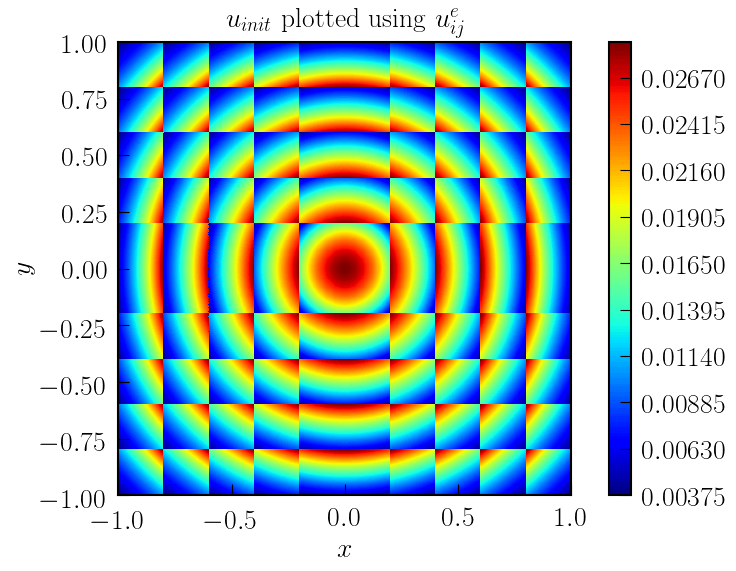

In [28]:

for element_tag in np.arange(len(elements)):
    print(element_tag)
    plt.contourf(np.array(af.moddims(x_e_ij[:, element_tag], d0 = N_LGL, d1 = N_LGL)),
                 np.array(af.moddims(y_e_ij[:, element_tag], d0 = N_LGL, d1 = N_LGL)),
                 np.array(af.moddims(u_e_ij[:, element_tag], d0 = N_LGL, d1 = N_LGL)),
                 200, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r'$u_{init}$ plotted using $u^e_{ij}$')
plt.colorbar()

plt.savefig('u_e_ij.png')
plt.show()

In [ ]:
print(deta_dy)

In [ ]:
print(A_inverse)

In [ ]:
af.sum(volume_integral_e_ij[:, 46][4] --367.619734412963)

In [ ]:
print( 1e-3 * af.matmul(A_inverse, b)[:, :10])

In [ ]:
print(G_ab[1][1])

In [17]:
print(af.np_to_af_array(nodes[elements[45]]))

arrayfire.Array()
Type: double

[9 2 1 1]
    0.0000     0.2000 
    0.0000     0.1000 
    0.0000     0.0000 
    0.1000    -0.0000 
    0.2000    -0.0000 
    0.2000     0.1000 
    0.2000     0.2000 
    0.1000     0.2000 
    0.1000     0.1000 


